# One shot learning siamese network for omniglot dataset
### Implementation of the following paper
Siamese Neural Networks for One-shot Image Recognition (Gregory et.al)

## Requirements


1.   Pytorch >= 0.4.0
2.   Python 3.5+

## Deep Siamese Networks for Image Verification 
Siamese  nets  were  first  introduced  in  the  early  1990s  by
Bromley and LeCun to solve signature verification as an
image matching problem. A siamese neural network consists of twin networks which accept distinct inputs but are joined by an energy function at the top. This function computes some metric between the highest-level feature representation on each side. Also, the network is symmetric, so that whenever we present two distinct images to the twin networks, the top conjoining layer will compute the same metric as if we were to we present the same two images but to the opposite twins.

The aim is to  first  learn  a  neural  network  that  can  discriminate between  the  class-identity  of  image  pairs,  which  is  the standard verification task for image recognition.  The verification model learns to identify input pairs according to the probability  that  they  belong  to  the  same  class  or  different classes.  This model can then be used to evaluate new images, exactly one per novel class, in a pairwise manner against the test image.  The pairing with the highest score according to the verification network is then awarded the highest  probability  for  the  one-shot  task.   If  the  features learned by the verification model are sufficient to confirm or deny the identity of characters from one set of alphabets,  then they ought to be sufficient for other alphabets, provided that the model has been exposed to a variety of alphabets to encourage variance amongst the learned features.


<img src="img/figure1.png"></img>


### Step1- Setting up the workspace
Download the Omniglot dataset and unzip it in the workspace (in this case workspace is 'Omniglot'). Save the data in two folders 'images_background' and 'images_evaluation' respectively. 

### Step2- Installing frameworks and impoting libraries
Importing all the libraries, dependencies and the framework required using the following commands
!pip install torch torchvision
!pip install Pillow==4.0.0
!pip install image


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from numpy.random import choice as npc
import numpy as np
import time
import random
import torchvision.datasets as dset
from PIL import Image
import pickle
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch.nn as nn
import torch.nn.functional as F

## Omniglot dataset

The Omniglot data set was collected by Brenden Lake and
his collaborators at MIT via Amazon’s Mechanical Turk to
produce a standard benchmark for learning from few examples in the handwritten character recognition domain.
Omniglot contains examples from 50 alphabets ranging from well established international languages like Latin and Korean to lesser known local dialects. The number of letters in each alphabet varies considerably
from  about  15  to  upwards  of  40  characters
<img src= "img/figure2.png"></img>

### Step3- Preprocessing training dataset
Creating a class for loading training dataset which samples two random images and gives it a label =1.0 if they belong to the same class or label= 0.0 if they belong to different class. Each pair is given a specific index.

In [2]:
class OmniglotTrain(Dataset):

    def __init__(self, dataset, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        self.dataset = dataset
        self.transform = transform
        self.img1 = None

    def __len__(self):
        return  21000000

    def __getitem__(self, index):
        image1 = random.choice(self.dataset.imgs)
        # get image from same class
        label = None
        if index % 2 == 1:
            label = 1.0
            while True:
                image2 = random.choice(self.dataset.imgs)
                if image1[1] == image2[1]:
                    break
        # get image from different class
        else:
            label = 0.0
            while True:
                image2 = random.choice(self.dataset.imgs)
                if image1[1] != image2[1]:
                    break
        image1 = Image.open(image1[0])
        image2 = Image.open(image2[0])
        image1 = image1.convert('L')
        image2 = image2.convert('L')

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))

### Step4 - Preprocessing testing data
Creating a class for loading test dataset. This class samples two random images from the test dataset and gives it a specific index. As it is a 20 way classification, one in 20 pairs belongs to the same class. Each class gets one example.

In [3]:
class OmniglotTest(Dataset):

    def __init__(self, dataset, transform=None, times=200, way=20):
        np.random.seed(1)
        super(OmniglotTest, self).__init__()
        self.dataset = dataset
        self.transform = transform
        self.times = times
        self.way = way

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.img1 = random.choice(self.dataset.imgs)
            while True:
                img2 = random.choice(self.dataset.imgs)
                if self.img1[1] == img2[1]:
                    break
        # generate image pair from different class
        else:
            while True:
                img2 = random.choice(self.dataset.imgs)
                if self.img1[1] != img2[1]:
                    break

        img1 = Image.open(self.img1[0])
        img2 = Image.open(img2[0])
        img1 = img1.convert('L')
        img2 = img2.convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2


### Step 5- Model

<img src="img/download.png"></img>

The model consists of a sequence of convolutional layers, each of which uses a single channel with filters of varying
size and a fixed stride of 1.  The number of convolutional filters is specified as a multiple of 16 to optimize performance.   The network applies a ReLU activation function to  the  output  feature  maps,  optionally  followed  by  max-pooling with a filter size and stride of 2.

The units in the final convolutional layer are flattened into a  single  vector.   This  convolutional  layer  is  followed  by a  fully-connected  layer,  and  then  one  more  layer  computing the induced distance metric between each siamese twin,  which  is  given  to  a  single  sigmoidal  output  unit.


In [4]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

### Step 6- GPU check
check whether CUDA is working

In [5]:
cuda = torch.cuda.is_available()
print("Cuda: " + str(cuda))          #Checking if CUDA is available

Cuda: True


### Step 7- Affine distortions
Augmenting the training set with small affine distortions.  For each
image  pair
x1, x2,  we  generated  a  pair  of  affine  transformations T1, T2 to  yield x′1= T1(x1), x′2=T2(x2), where T1, T2 are determined  stochastically  by  a  multi-dimensional uniform distribution. 
<img src= "img/figure4.png"></img>

In [6]:
data_transforms = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ToTensor()
])

### Step 8- Setting up the path for loading training and testing dataset

In [7]:
train_path = 'training'
test_path = 'evaluation'
train_dataset = dset.ImageFolder(root=train_path)
test_dataset = dset.ImageFolder(root=test_path)

### Step 9- Loading the data and creating pairs for training and testing with Affine distortions

In [8]:
way = 20
times = 400

dataSet = OmniglotTrain(train_dataset, transform=data_transforms)
testSet = OmniglotTest(test_dataset, transform=transforms.ToTensor(), times = times, way = way)
testLoader = DataLoader(testSet, batch_size=way, shuffle=False, num_workers=16)

dataLoader = DataLoader(dataSet, batch_size=128,\
                        shuffle=False, num_workers=16)

### Step 10- Loss function

A regularized cross-entropy objective on our binary classifier

In [9]:
loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
learning_rate = 0.0006
net = Siamese()
train_loss = []
net.train()
if cuda:
    net.cuda()

/home/ameya/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


### Step 11- Optimizer
Used a standarised Adam optimizer

In [10]:
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate )
optimizer.zero_grad()

### Step 12- Setting up the parameters

In [11]:
show_every = 10
save_every = 100
test_every = 100
train_loss = []
loss_val = 0
max_iter = 90000
losses=[]
batch_ids= []

### Step 13- Training and testing after every 100 batch size

In [12]:
for batch_id, (img1, img2, label) in enumerate(dataLoader, 1):
    if batch_id > max_iter:
        break
    batch_start = time.time()
    if cuda:
        img1, img2, label = Variable(img1.cuda()), Variable(img2.cuda()), Variable(label.cuda())
    else:
        img1, img2, label = Variable(img1), Variable(img2), Variable(label)
    optimizer.zero_grad()
    output = net.forward(img1, img2)
    loss = loss_fn(output, label)
    loss_val += loss.item()
    loss.backward()
    optimizer.step()
    if batch_id % show_every == 0 :
        print('[%d]\tloss:\t%.5f\tTook\t%.2f s'%(batch_id, loss_val/show_every, (time.time() - batch_start)*show_every))
        batch_ids.append(float(batch_id))
        losses.append(loss_val/show_every)
        loss_val = 0
    if batch_id % save_every == 0:
        torch.save(net.state_dict(), 'model/model-batch-%d.pth'%(batch_id+1,))
    if batch_id % test_every == 0:
        right, error = 0, 0
        for _, (test1, test2) in enumerate(testLoader, 1):
            if cuda:
                test1, test2 = test1.cuda(), test2.cuda()
            test1, test2 = Variable(test1), Variable(test2)
            output = net.forward(test1, test2).data.cpu().numpy()
            pred = np.argmax(output)
            if pred == 0:
                right += 1
            else: error += 1
        print('*'*70)
        print('[%d]\tright:\t%d\terror:\t%d\tprecision:\t%f'%(batch_id, right, error, right*1.0/(right+error)))
        print('*'*70)
    train_loss.append(loss_val)
#  learning_rate = learning_rate * 0.95

with open('train_loss', 'wb') as f:
    pickle.dump(train_loss, f)

[10]	loss:	0.65452	Took	2.42 s
[20]	loss:	0.60420	Took	2.41 s
[30]	loss:	0.62870	Took	2.41 s
[40]	loss:	0.60237	Took	2.40 s
[50]	loss:	0.57514	Took	2.40 s
[60]	loss:	0.54302	Took	2.39 s
[70]	loss:	0.57615	Took	2.65 s
[80]	loss:	0.55044	Took	2.65 s
[90]	loss:	0.54529	Took	2.69 s
[100]	loss:	0.52937	Took	2.70 s
**********************************************************************
[100]	right:	76	error:	324	precision:	0.190000
**********************************************************************
[110]	loss:	0.52348	Took	2.39 s
[120]	loss:	0.51615	Took	2.38 s
[130]	loss:	0.51226	Took	2.39 s
[140]	loss:	0.49360	Took	2.38 s
[150]	loss:	0.47295	Took	2.41 s
[160]	loss:	0.50005	Took	2.39 s
[170]	loss:	0.45099	Took	2.40 s
[180]	loss:	0.47946	Took	2.40 s
[190]	loss:	0.43579	Took	2.41 s
[200]	loss:	0.42864	Took	2.40 s
**********************************************************************
[200]	right:	104	error:	296	precision:	0.260000
*************************************************************

[1610]	loss:	0.13046	Took	2.41 s
[1620]	loss:	0.10188	Took	2.41 s
[1630]	loss:	0.12341	Took	2.41 s
[1640]	loss:	0.12957	Took	2.42 s
[1650]	loss:	0.11692	Took	2.42 s
[1660]	loss:	0.12897	Took	2.41 s
[1670]	loss:	0.13751	Took	2.41 s
[1680]	loss:	0.13716	Took	2.42 s
[1690]	loss:	0.15131	Took	2.41 s
[1700]	loss:	0.11543	Took	2.40 s
**********************************************************************
[1700]	right:	271	error:	129	precision:	0.677500
**********************************************************************
[1710]	loss:	0.11763	Took	2.41 s
[1720]	loss:	0.13637	Took	2.42 s
[1730]	loss:	0.13241	Took	2.42 s
[1740]	loss:	0.13095	Took	2.41 s
[1750]	loss:	0.13882	Took	2.41 s
[1760]	loss:	0.11824	Took	2.41 s
[1770]	loss:	0.12619	Took	2.41 s
[1780]	loss:	0.13965	Took	2.42 s
[1790]	loss:	0.11898	Took	2.41 s
[1800]	loss:	0.13183	Took	2.41 s
**********************************************************************
[1800]	right:	287	error:	113	precision:	0.717500
*****************************

[3210]	loss:	0.06620	Took	2.41 s
[3220]	loss:	0.08500	Took	2.41 s
[3230]	loss:	0.08122	Took	2.42 s
[3240]	loss:	0.07321	Took	2.41 s
[3250]	loss:	0.08217	Took	2.42 s
[3260]	loss:	0.08794	Took	2.41 s
[3270]	loss:	0.07187	Took	2.41 s
[3280]	loss:	0.09967	Took	2.42 s
[3290]	loss:	0.08633	Took	2.40 s
[3300]	loss:	0.08257	Took	2.41 s
**********************************************************************
[3300]	right:	325	error:	75	precision:	0.812500
**********************************************************************
[3310]	loss:	0.08807	Took	2.41 s
[3320]	loss:	0.09341	Took	2.41 s
[3330]	loss:	0.08339	Took	2.42 s
[3340]	loss:	0.06722	Took	2.42 s
[3350]	loss:	0.07441	Took	2.41 s
[3360]	loss:	0.08766	Took	2.41 s
[3370]	loss:	0.07917	Took	2.41 s
[3380]	loss:	0.08668	Took	2.41 s
[3390]	loss:	0.08327	Took	2.42 s
[3400]	loss:	0.08975	Took	2.41 s
**********************************************************************
[3400]	right:	322	error:	78	precision:	0.805000
*******************************

[4810]	loss:	0.06678	Took	2.40 s
[4820]	loss:	0.05878	Took	2.42 s
[4830]	loss:	0.06008	Took	2.40 s
[4840]	loss:	0.06152	Took	2.41 s
[4850]	loss:	0.06856	Took	2.42 s
[4860]	loss:	0.05236	Took	2.41 s
[4870]	loss:	0.07833	Took	2.43 s
[4880]	loss:	0.04785	Took	2.41 s
[4890]	loss:	0.07038	Took	2.41 s
[4900]	loss:	0.05258	Took	2.41 s
**********************************************************************
[4900]	right:	305	error:	95	precision:	0.762500
**********************************************************************
[4910]	loss:	0.07346	Took	2.42 s
[4920]	loss:	0.06451	Took	2.41 s
[4930]	loss:	0.07445	Took	2.42 s
[4940]	loss:	0.06879	Took	2.42 s
[4950]	loss:	0.05230	Took	2.41 s
[4960]	loss:	0.06554	Took	2.42 s
[4970]	loss:	0.06004	Took	2.41 s
[4980]	loss:	0.05946	Took	2.41 s
[4990]	loss:	0.08304	Took	2.42 s
[5000]	loss:	0.05179	Took	2.41 s
**********************************************************************
[5000]	right:	313	error:	87	precision:	0.782500
*******************************

[6410]	loss:	0.05026	Took	2.41 s
[6420]	loss:	0.06132	Took	2.40 s
[6430]	loss:	0.05449	Took	2.40 s
[6440]	loss:	0.05216	Took	2.41 s
[6450]	loss:	0.04765	Took	2.41 s
[6460]	loss:	0.04699	Took	2.41 s
[6470]	loss:	0.05277	Took	2.40 s
[6480]	loss:	0.03480	Took	2.43 s
[6490]	loss:	0.05650	Took	2.40 s
[6500]	loss:	0.06491	Took	2.39 s
**********************************************************************
[6500]	right:	335	error:	65	precision:	0.837500
**********************************************************************
[6510]	loss:	0.03936	Took	2.41 s
[6520]	loss:	0.05687	Took	2.41 s
[6530]	loss:	0.05501	Took	2.41 s
[6540]	loss:	0.05248	Took	2.40 s
[6550]	loss:	0.04544	Took	2.41 s
[6560]	loss:	0.06392	Took	2.43 s
[6570]	loss:	0.04708	Took	2.41 s
[6580]	loss:	0.04955	Took	2.41 s
[6590]	loss:	0.05648	Took	2.41 s
[6600]	loss:	0.05200	Took	2.40 s
**********************************************************************
[6600]	right:	337	error:	63	precision:	0.842500
*******************************

[8010]	loss:	0.04226	Took	2.41 s
[8020]	loss:	0.03566	Took	2.41 s
[8030]	loss:	0.03640	Took	2.40 s
[8040]	loss:	0.06465	Took	2.40 s
[8050]	loss:	0.04296	Took	2.40 s
[8060]	loss:	0.04139	Took	2.42 s
[8070]	loss:	0.05012	Took	2.40 s
[8080]	loss:	0.04382	Took	2.40 s
[8090]	loss:	0.05161	Took	2.39 s
[8100]	loss:	0.04626	Took	2.40 s
**********************************************************************
[8100]	right:	329	error:	71	precision:	0.822500
**********************************************************************
[8110]	loss:	0.04129	Took	2.40 s
[8120]	loss:	0.04061	Took	2.41 s
[8130]	loss:	0.03750	Took	2.40 s
[8140]	loss:	0.04739	Took	2.39 s
[8150]	loss:	0.03835	Took	2.41 s
[8160]	loss:	0.04390	Took	2.41 s
[8170]	loss:	0.04418	Took	2.40 s
[8180]	loss:	0.06048	Took	2.40 s
[8190]	loss:	0.04635	Took	2.40 s
[8200]	loss:	0.04499	Took	2.41 s
**********************************************************************
[8200]	right:	336	error:	64	precision:	0.840000
*******************************

[9610]	loss:	0.02941	Took	2.40 s
[9620]	loss:	0.03197	Took	2.41 s
[9630]	loss:	0.02708	Took	2.42 s
[9640]	loss:	0.03496	Took	2.40 s
[9650]	loss:	0.02491	Took	2.41 s
[9660]	loss:	0.04617	Took	2.40 s
[9670]	loss:	0.06091	Took	2.41 s
[9680]	loss:	0.03449	Took	2.41 s
[9690]	loss:	0.03711	Took	2.41 s
[9700]	loss:	0.02524	Took	2.40 s
**********************************************************************
[9700]	right:	322	error:	78	precision:	0.805000
**********************************************************************
[9710]	loss:	0.03715	Took	2.40 s
[9720]	loss:	0.03336	Took	2.40 s
[9730]	loss:	0.02644	Took	2.40 s
[9740]	loss:	0.03764	Took	2.39 s
[9750]	loss:	0.05432	Took	2.39 s
[9760]	loss:	0.03837	Took	2.41 s
[9770]	loss:	0.03642	Took	2.40 s
[9780]	loss:	0.05538	Took	2.39 s
[9790]	loss:	0.03307	Took	2.39 s
[9800]	loss:	0.04685	Took	2.42 s
**********************************************************************
[9800]	right:	332	error:	68	precision:	0.830000
*******************************

[11190]	loss:	0.03637	Took	2.42 s
[11200]	loss:	0.02636	Took	2.39 s
**********************************************************************
[11200]	right:	336	error:	64	precision:	0.840000
**********************************************************************
[11210]	loss:	0.02630	Took	2.41 s
[11220]	loss:	0.04208	Took	2.41 s
[11230]	loss:	0.03236	Took	2.40 s
[11240]	loss:	0.03496	Took	2.42 s
[11250]	loss:	0.04017	Took	2.41 s
[11260]	loss:	0.03229	Took	2.41 s
[11270]	loss:	0.03948	Took	2.40 s
[11280]	loss:	0.04789	Took	2.41 s
[11290]	loss:	0.04061	Took	2.43 s
[11300]	loss:	0.03523	Took	2.40 s
**********************************************************************
[11300]	right:	333	error:	67	precision:	0.832500
**********************************************************************
[11310]	loss:	0.04004	Took	2.40 s
[11320]	loss:	0.03855	Took	2.40 s
[11330]	loss:	0.04914	Took	2.42 s
[11340]	loss:	0.04558	Took	2.40 s
[11350]	loss:	0.02868	Took	2.40 s
[11360]	loss:	0.05351	Took	2.42 s
[11370

[12710]	loss:	0.03523	Took	2.41 s
[12720]	loss:	0.02667	Took	2.40 s
[12730]	loss:	0.02143	Took	2.41 s
[12740]	loss:	0.04522	Took	2.38 s
[12750]	loss:	0.02249	Took	2.40 s
[12760]	loss:	0.04130	Took	2.39 s
[12770]	loss:	0.02600	Took	2.41 s
[12780]	loss:	0.03020	Took	2.39 s
[12790]	loss:	0.04655	Took	2.39 s
[12800]	loss:	0.02644	Took	2.41 s
**********************************************************************
[12800]	right:	339	error:	61	precision:	0.847500
**********************************************************************
[12810]	loss:	0.03115	Took	2.39 s
[12820]	loss:	0.03491	Took	2.39 s
[12830]	loss:	0.02465	Took	2.41 s
[12840]	loss:	0.03116	Took	2.40 s
[12850]	loss:	0.05422	Took	2.41 s
[12860]	loss:	0.02317	Took	2.40 s
[12870]	loss:	0.02928	Took	2.41 s
[12880]	loss:	0.02270	Took	2.40 s
[12890]	loss:	0.02960	Took	2.41 s
[12900]	loss:	0.03406	Took	2.40 s
**********************************************************************
[12900]	right:	352	error:	48	precision:	0.880000
*********

[14280]	loss:	0.02050	Took	2.39 s
[14290]	loss:	0.02731	Took	2.40 s
[14300]	loss:	0.02900	Took	2.40 s
**********************************************************************
[14300]	right:	343	error:	57	precision:	0.857500
**********************************************************************
[14310]	loss:	0.02241	Took	2.39 s
[14320]	loss:	0.03648	Took	2.38 s
[14330]	loss:	0.03204	Took	2.39 s
[14340]	loss:	0.02458	Took	2.41 s
[14350]	loss:	0.04428	Took	2.40 s
[14360]	loss:	0.03042	Took	2.42 s
[14370]	loss:	0.03276	Took	2.39 s
[14380]	loss:	0.03259	Took	2.40 s
[14390]	loss:	0.02530	Took	2.40 s
[14400]	loss:	0.01248	Took	2.40 s
**********************************************************************
[14400]	right:	327	error:	73	precision:	0.817500
**********************************************************************
[14410]	loss:	0.01690	Took	2.39 s
[14420]	loss:	0.01998	Took	2.38 s
[14430]	loss:	0.01892	Took	2.40 s
[14440]	loss:	0.01807	Took	2.40 s
[14450]	loss:	0.02245	Took	2.40 s
[14460

[15810]	loss:	0.02027	Took	2.40 s
[15820]	loss:	0.02378	Took	2.41 s
[15830]	loss:	0.02701	Took	2.40 s
[15840]	loss:	0.02792	Took	2.40 s
[15850]	loss:	0.03884	Took	2.40 s
[15860]	loss:	0.01286	Took	2.41 s
[15870]	loss:	0.02413	Took	2.41 s
[15880]	loss:	0.02999	Took	2.39 s
[15890]	loss:	0.02968	Took	2.41 s
[15900]	loss:	0.03302	Took	2.41 s
**********************************************************************
[15900]	right:	331	error:	69	precision:	0.827500
**********************************************************************
[15910]	loss:	0.02344	Took	2.39 s
[15920]	loss:	0.02738	Took	2.40 s
[15930]	loss:	0.03620	Took	2.40 s
[15940]	loss:	0.02640	Took	2.40 s
[15950]	loss:	0.04755	Took	2.41 s
[15960]	loss:	0.03422	Took	2.41 s
[15970]	loss:	0.02702	Took	2.41 s
[15980]	loss:	0.01629	Took	2.39 s
[15990]	loss:	0.01642	Took	2.39 s
[16000]	loss:	0.03797	Took	2.40 s
**********************************************************************
[16000]	right:	348	error:	52	precision:	0.870000
*********

[17380]	loss:	0.01730	Took	2.42 s
[17390]	loss:	0.02809	Took	2.44 s
[17400]	loss:	0.02838	Took	2.39 s
**********************************************************************
[17400]	right:	351	error:	49	precision:	0.877500
**********************************************************************
[17410]	loss:	0.03295	Took	2.41 s
[17420]	loss:	0.03614	Took	2.39 s
[17430]	loss:	0.02393	Took	2.37 s
[17440]	loss:	0.02873	Took	2.40 s
[17450]	loss:	0.03413	Took	2.39 s
[17460]	loss:	0.02930	Took	2.40 s
[17470]	loss:	0.01958	Took	2.42 s
[17480]	loss:	0.02578	Took	2.39 s
[17490]	loss:	0.03530	Took	2.39 s
[17500]	loss:	0.01618	Took	2.39 s
**********************************************************************
[17500]	right:	342	error:	58	precision:	0.855000
**********************************************************************
[17510]	loss:	0.02012	Took	2.40 s
[17520]	loss:	0.02924	Took	2.41 s
[17530]	loss:	0.02148	Took	2.40 s
[17540]	loss:	0.02745	Took	2.38 s
[17550]	loss:	0.02588	Took	2.42 s
[17560

[18910]	loss:	0.03566	Took	2.41 s
[18920]	loss:	0.03340	Took	2.41 s
[18930]	loss:	0.01686	Took	2.39 s
[18940]	loss:	0.01703	Took	2.40 s
[18950]	loss:	0.02549	Took	2.40 s
[18960]	loss:	0.01608	Took	2.41 s
[18970]	loss:	0.02764	Took	2.40 s
[18980]	loss:	0.03740	Took	2.40 s
[18990]	loss:	0.02033	Took	2.40 s
[19000]	loss:	0.03090	Took	2.41 s
**********************************************************************
[19000]	right:	350	error:	50	precision:	0.875000
**********************************************************************
[19010]	loss:	0.02825	Took	2.40 s
[19020]	loss:	0.01705	Took	2.41 s
[19030]	loss:	0.01270	Took	2.40 s
[19040]	loss:	0.02516	Took	2.39 s
[19050]	loss:	0.04135	Took	2.40 s
[19060]	loss:	0.02512	Took	2.40 s
[19070]	loss:	0.02954	Took	2.40 s
[19080]	loss:	0.02878	Took	2.41 s
[19090]	loss:	0.02287	Took	2.40 s
[19100]	loss:	0.02132	Took	2.40 s
**********************************************************************
[19100]	right:	341	error:	59	precision:	0.852500
*********

[20480]	loss:	0.01479	Took	2.41 s
[20490]	loss:	0.03214	Took	2.39 s
[20500]	loss:	0.03287	Took	2.41 s
**********************************************************************
[20500]	right:	346	error:	54	precision:	0.865000
**********************************************************************
[20510]	loss:	0.03068	Took	2.40 s
[20520]	loss:	0.02743	Took	2.40 s
[20530]	loss:	0.02265	Took	2.40 s
[20540]	loss:	0.03142	Took	2.41 s
[20550]	loss:	0.03859	Took	2.40 s
[20560]	loss:	0.02180	Took	2.41 s
[20570]	loss:	0.02998	Took	2.39 s
[20580]	loss:	0.02820	Took	2.40 s
[20590]	loss:	0.02377	Took	2.40 s
[20600]	loss:	0.01077	Took	2.40 s
**********************************************************************
[20600]	right:	344	error:	56	precision:	0.860000
**********************************************************************
[20610]	loss:	0.02026	Took	2.39 s
[20620]	loss:	0.02740	Took	2.41 s
[20630]	loss:	0.02163	Took	2.39 s
[20640]	loss:	0.02470	Took	2.41 s
[20650]	loss:	0.02780	Took	2.40 s
[20660

[22010]	loss:	0.02457	Took	2.40 s
[22020]	loss:	0.02429	Took	2.41 s
[22030]	loss:	0.03281	Took	2.40 s
[22040]	loss:	0.00988	Took	2.41 s
[22050]	loss:	0.02073	Took	2.40 s
[22060]	loss:	0.01826	Took	2.40 s
[22070]	loss:	0.02432	Took	2.39 s
[22080]	loss:	0.03275	Took	2.41 s
[22090]	loss:	0.01791	Took	2.41 s
[22100]	loss:	0.01889	Took	2.40 s
**********************************************************************
[22100]	right:	342	error:	58	precision:	0.855000
**********************************************************************
[22110]	loss:	0.01682	Took	2.41 s
[22120]	loss:	0.05007	Took	2.39 s
[22130]	loss:	0.02631	Took	2.41 s
[22140]	loss:	0.02471	Took	2.40 s
[22150]	loss:	0.01252	Took	2.41 s
[22160]	loss:	0.02032	Took	2.40 s
[22170]	loss:	0.04499	Took	2.39 s
[22180]	loss:	0.03057	Took	2.39 s
[22190]	loss:	0.02276	Took	2.38 s
[22200]	loss:	0.02681	Took	2.39 s
**********************************************************************
[22200]	right:	342	error:	58	precision:	0.855000
*********

[23580]	loss:	0.02746	Took	2.40 s
[23590]	loss:	0.01961	Took	2.40 s
[23600]	loss:	0.01666	Took	2.39 s
**********************************************************************
[23600]	right:	341	error:	59	precision:	0.852500
**********************************************************************
[23610]	loss:	0.02482	Took	2.40 s
[23620]	loss:	0.02747	Took	2.39 s
[23630]	loss:	0.01798	Took	2.39 s
[23640]	loss:	0.01956	Took	2.38 s
[23650]	loss:	0.01264	Took	2.41 s
[23660]	loss:	0.00963	Took	2.40 s
[23670]	loss:	0.02704	Took	2.39 s
[23680]	loss:	0.01695	Took	2.38 s
[23690]	loss:	0.01038	Took	2.39 s
[23700]	loss:	0.01331	Took	2.39 s
**********************************************************************
[23700]	right:	346	error:	54	precision:	0.865000
**********************************************************************
[23710]	loss:	0.01188	Took	2.41 s
[23720]	loss:	0.01228	Took	2.37 s
[23730]	loss:	0.02561	Took	2.39 s
[23740]	loss:	0.02809	Took	2.40 s
[23750]	loss:	0.02657	Took	2.38 s
[23760

[25110]	loss:	0.01892	Took	2.39 s
[25120]	loss:	0.01382	Took	2.40 s
[25130]	loss:	0.03573	Took	2.43 s
[25140]	loss:	0.02922	Took	2.40 s
[25150]	loss:	0.02115	Took	2.39 s
[25160]	loss:	0.01923	Took	2.40 s
[25170]	loss:	0.02476	Took	2.40 s
[25180]	loss:	0.02439	Took	2.40 s
[25190]	loss:	0.02787	Took	2.40 s
[25200]	loss:	0.00707	Took	2.40 s
**********************************************************************
[25200]	right:	355	error:	45	precision:	0.887500
**********************************************************************
[25210]	loss:	0.01958	Took	2.41 s
[25220]	loss:	0.02652	Took	2.39 s
[25230]	loss:	0.03329	Took	2.39 s
[25240]	loss:	0.02917	Took	2.40 s
[25250]	loss:	0.02993	Took	2.38 s
[25260]	loss:	0.02177	Took	2.39 s
[25270]	loss:	0.02613	Took	2.40 s
[25280]	loss:	0.01685	Took	2.40 s
[25290]	loss:	0.02499	Took	2.39 s
[25300]	loss:	0.02110	Took	2.39 s
**********************************************************************
[25300]	right:	346	error:	54	precision:	0.865000
*********

[26680]	loss:	0.01947	Took	2.39 s
[26690]	loss:	0.01584	Took	2.39 s
[26700]	loss:	0.01962	Took	2.38 s
**********************************************************************
[26700]	right:	360	error:	40	precision:	0.900000
**********************************************************************
[26710]	loss:	0.02311	Took	2.40 s
[26720]	loss:	0.02724	Took	2.41 s
[26730]	loss:	0.02445	Took	2.39 s
[26740]	loss:	0.03065	Took	2.39 s
[26750]	loss:	0.02549	Took	2.37 s
[26760]	loss:	0.01276	Took	2.41 s
[26770]	loss:	0.01745	Took	2.39 s
[26780]	loss:	0.01889	Took	2.40 s
[26790]	loss:	0.02070	Took	2.42 s
[26800]	loss:	0.01853	Took	2.41 s
**********************************************************************
[26800]	right:	354	error:	46	precision:	0.885000
**********************************************************************
[26810]	loss:	0.01968	Took	2.39 s
[26820]	loss:	0.02434	Took	2.40 s
[26830]	loss:	0.02218	Took	2.41 s
[26840]	loss:	0.02229	Took	2.39 s
[26850]	loss:	0.04020	Took	2.40 s
[26860

[28210]	loss:	0.01118	Took	2.39 s
[28220]	loss:	0.01009	Took	2.39 s
[28230]	loss:	0.01899	Took	2.40 s
[28240]	loss:	0.00675	Took	2.39 s
[28250]	loss:	0.01625	Took	2.38 s
[28260]	loss:	0.01868	Took	2.39 s
[28270]	loss:	0.01199	Took	2.38 s
[28280]	loss:	0.04634	Took	2.39 s
[28290]	loss:	0.03295	Took	2.41 s
[28300]	loss:	0.02971	Took	2.38 s
**********************************************************************
[28300]	right:	354	error:	46	precision:	0.885000
**********************************************************************
[28310]	loss:	0.02492	Took	2.40 s
[28320]	loss:	0.00966	Took	2.38 s
[28330]	loss:	0.03294	Took	2.39 s
[28340]	loss:	0.02507	Took	2.39 s
[28350]	loss:	0.02814	Took	2.38 s
[28360]	loss:	0.01854	Took	2.38 s
[28370]	loss:	0.01805	Took	2.39 s
[28380]	loss:	0.01208	Took	2.40 s
[28390]	loss:	0.00791	Took	2.40 s
[28400]	loss:	0.01438	Took	2.39 s
**********************************************************************
[28400]	right:	350	error:	50	precision:	0.875000
*********

[29780]	loss:	0.01790	Took	2.41 s
[29790]	loss:	0.02357	Took	2.40 s
[29800]	loss:	0.01554	Took	2.38 s
**********************************************************************
[29800]	right:	326	error:	74	precision:	0.815000
**********************************************************************
[29810]	loss:	0.01321	Took	2.40 s
[29820]	loss:	0.01249	Took	2.39 s
[29830]	loss:	0.01945	Took	2.39 s
[29840]	loss:	0.02690	Took	2.40 s
[29850]	loss:	0.02288	Took	2.38 s
[29860]	loss:	0.02428	Took	2.40 s
[29870]	loss:	0.02151	Took	2.41 s
[29880]	loss:	0.02302	Took	2.40 s
[29890]	loss:	0.01047	Took	2.40 s
[29900]	loss:	0.01342	Took	2.39 s
**********************************************************************
[29900]	right:	348	error:	52	precision:	0.870000
**********************************************************************
[29910]	loss:	0.01766	Took	2.39 s
[29920]	loss:	0.02707	Took	2.40 s
[29930]	loss:	0.01415	Took	2.38 s
[29940]	loss:	0.01337	Took	2.37 s
[29950]	loss:	0.02396	Took	2.38 s
[29960

[31310]	loss:	0.03454	Took	2.39 s
[31320]	loss:	0.02755	Took	2.39 s
[31330]	loss:	0.03361	Took	2.40 s
[31340]	loss:	0.01368	Took	2.41 s
[31350]	loss:	0.01485	Took	2.40 s
[31360]	loss:	0.01574	Took	2.40 s
[31370]	loss:	0.02097	Took	2.39 s
[31380]	loss:	0.02091	Took	2.41 s
[31390]	loss:	0.02669	Took	2.41 s
[31400]	loss:	0.01506	Took	2.39 s
**********************************************************************
[31400]	right:	344	error:	56	precision:	0.860000
**********************************************************************
[31410]	loss:	0.01324	Took	2.38 s
[31420]	loss:	0.00979	Took	2.38 s
[31430]	loss:	0.01448	Took	2.39 s
[31440]	loss:	0.01535	Took	2.39 s
[31450]	loss:	0.01117	Took	2.37 s
[31460]	loss:	0.01298	Took	2.41 s
[31470]	loss:	0.00573	Took	2.41 s
[31480]	loss:	0.03004	Took	2.39 s
[31490]	loss:	0.01149	Took	2.39 s
[31500]	loss:	0.01145	Took	2.41 s
**********************************************************************
[31500]	right:	344	error:	56	precision:	0.860000
*********

[32880]	loss:	0.01510	Took	2.39 s
[32890]	loss:	0.01683	Took	2.41 s
[32900]	loss:	0.01308	Took	2.39 s
**********************************************************************
[32900]	right:	338	error:	62	precision:	0.845000
**********************************************************************
[32910]	loss:	0.01868	Took	2.39 s
[32920]	loss:	0.01294	Took	2.39 s
[32930]	loss:	0.01823	Took	2.39 s
[32940]	loss:	0.01236	Took	2.39 s
[32950]	loss:	0.00740	Took	2.41 s
[32960]	loss:	0.00840	Took	2.41 s
[32970]	loss:	0.00980	Took	2.39 s
[32980]	loss:	0.01975	Took	2.39 s
[32990]	loss:	0.01874	Took	2.38 s
[33000]	loss:	0.02010	Took	2.41 s
**********************************************************************
[33000]	right:	352	error:	48	precision:	0.880000
**********************************************************************
[33010]	loss:	0.01141	Took	2.40 s
[33020]	loss:	0.01560	Took	2.40 s
[33030]	loss:	0.01081	Took	2.41 s
[33040]	loss:	0.01951	Took	2.39 s
[33050]	loss:	0.01252	Took	2.39 s
[33060

[34410]	loss:	0.01885	Took	2.39 s
[34420]	loss:	0.00655	Took	2.39 s
[34430]	loss:	0.01581	Took	2.38 s
[34440]	loss:	0.02414	Took	2.40 s
[34450]	loss:	0.01125	Took	2.38 s
[34460]	loss:	0.01525	Took	2.38 s
[34470]	loss:	0.01708	Took	2.39 s
[34480]	loss:	0.00428	Took	2.38 s
[34490]	loss:	0.01284	Took	2.41 s
[34500]	loss:	0.01261	Took	2.39 s
**********************************************************************
[34500]	right:	350	error:	50	precision:	0.875000
**********************************************************************
[34510]	loss:	0.01304	Took	2.39 s
[34520]	loss:	0.01142	Took	2.39 s
[34530]	loss:	0.01157	Took	2.38 s
[34540]	loss:	0.02399	Took	2.40 s
[34550]	loss:	0.01818	Took	2.41 s
[34560]	loss:	0.01625	Took	2.38 s
[34570]	loss:	0.00567	Took	2.39 s
[34580]	loss:	0.01010	Took	2.42 s
[34590]	loss:	0.02060	Took	2.41 s
[34600]	loss:	0.03722	Took	2.40 s
**********************************************************************
[34600]	right:	354	error:	46	precision:	0.885000
*********

[35980]	loss:	0.01184	Took	2.38 s
[35990]	loss:	0.02421	Took	2.39 s
[36000]	loss:	0.01600	Took	2.38 s
**********************************************************************
[36000]	right:	354	error:	46	precision:	0.885000
**********************************************************************
[36010]	loss:	0.02056	Took	2.39 s
[36020]	loss:	0.01866	Took	2.39 s
[36030]	loss:	0.02422	Took	2.40 s
[36040]	loss:	0.02811	Took	2.37 s
[36050]	loss:	0.01666	Took	2.39 s
[36060]	loss:	0.01402	Took	2.44 s
[36070]	loss:	0.01767	Took	2.39 s
[36080]	loss:	0.01314	Took	2.38 s
[36090]	loss:	0.02470	Took	2.38 s
[36100]	loss:	0.01520	Took	2.40 s
**********************************************************************
[36100]	right:	345	error:	55	precision:	0.862500
**********************************************************************
[36110]	loss:	0.00853	Took	2.40 s
[36120]	loss:	0.00779	Took	2.38 s
[36130]	loss:	0.00755	Took	2.40 s
[36140]	loss:	0.01632	Took	2.39 s
[36150]	loss:	0.00569	Took	2.40 s
[36160

[37510]	loss:	0.00743	Took	2.39 s
[37520]	loss:	0.01013	Took	2.40 s
[37530]	loss:	0.01347	Took	2.40 s
[37540]	loss:	0.01315	Took	2.39 s
[37550]	loss:	0.01555	Took	2.39 s
[37560]	loss:	0.02341	Took	2.39 s
[37570]	loss:	0.02249	Took	2.40 s
[37580]	loss:	0.01741	Took	2.39 s
[37590]	loss:	0.02586	Took	2.41 s
[37600]	loss:	0.01106	Took	2.42 s
**********************************************************************
[37600]	right:	344	error:	56	precision:	0.860000
**********************************************************************
[37610]	loss:	0.01133	Took	2.41 s
[37620]	loss:	0.01271	Took	2.39 s
[37630]	loss:	0.01501	Took	2.40 s
[37640]	loss:	0.01266	Took	2.41 s
[37650]	loss:	0.02228	Took	2.39 s
[37660]	loss:	0.01762	Took	2.39 s
[37670]	loss:	0.02711	Took	2.39 s
[37680]	loss:	0.02505	Took	2.41 s
[37690]	loss:	0.01280	Took	2.38 s
[37700]	loss:	0.01385	Took	2.39 s
**********************************************************************
[37700]	right:	346	error:	54	precision:	0.865000
*********

[39080]	loss:	0.01625	Took	2.39 s
[39090]	loss:	0.01017	Took	2.40 s
[39100]	loss:	0.00894	Took	2.38 s
**********************************************************************
[39100]	right:	340	error:	60	precision:	0.850000
**********************************************************************
[39110]	loss:	0.01476	Took	2.39 s
[39120]	loss:	0.01223	Took	2.39 s
[39130]	loss:	0.01014	Took	2.39 s
[39140]	loss:	0.01659	Took	2.39 s
[39150]	loss:	0.02231	Took	2.38 s
[39160]	loss:	0.01862	Took	2.40 s
[39170]	loss:	0.00854	Took	2.40 s
[39180]	loss:	0.01214	Took	2.41 s
[39190]	loss:	0.01144	Took	2.40 s
[39200]	loss:	0.00814	Took	2.39 s
**********************************************************************
[39200]	right:	339	error:	61	precision:	0.847500
**********************************************************************
[39210]	loss:	0.00644	Took	2.39 s
[39220]	loss:	0.01362	Took	2.41 s
[39230]	loss:	0.01701	Took	2.40 s
[39240]	loss:	0.01878	Took	2.39 s
[39250]	loss:	0.00596	Took	2.41 s
[39260

[40610]	loss:	0.01939	Took	2.38 s
[40620]	loss:	0.02484	Took	2.41 s
[40630]	loss:	0.01419	Took	2.38 s
[40640]	loss:	0.01380	Took	2.40 s
[40650]	loss:	0.00475	Took	2.41 s
[40660]	loss:	0.02662	Took	2.40 s
[40670]	loss:	0.00669	Took	2.38 s
[40680]	loss:	0.01169	Took	2.36 s
[40690]	loss:	0.01681	Took	2.41 s
[40700]	loss:	0.00716	Took	2.42 s
**********************************************************************
[40700]	right:	347	error:	53	precision:	0.867500
**********************************************************************
[40710]	loss:	0.01105	Took	2.40 s
[40720]	loss:	0.00670	Took	2.39 s
[40730]	loss:	0.00578	Took	2.39 s
[40740]	loss:	0.01853	Took	2.40 s
[40750]	loss:	0.01032	Took	2.39 s
[40760]	loss:	0.01927	Took	2.38 s
[40770]	loss:	0.01685	Took	2.39 s
[40780]	loss:	0.01455	Took	2.38 s
[40790]	loss:	0.01114	Took	2.40 s
[40800]	loss:	0.01507	Took	2.40 s
**********************************************************************
[40800]	right:	355	error:	45	precision:	0.887500
*********

[42180]	loss:	0.01803	Took	2.40 s
[42190]	loss:	0.00861	Took	2.40 s
[42200]	loss:	0.02547	Took	2.39 s
**********************************************************************
[42200]	right:	348	error:	52	precision:	0.870000
**********************************************************************
[42210]	loss:	0.01388	Took	2.39 s
[42220]	loss:	0.01277	Took	2.39 s
[42230]	loss:	0.02065	Took	2.39 s
[42240]	loss:	0.02531	Took	2.39 s
[42250]	loss:	0.00999	Took	2.40 s
[42260]	loss:	0.01895	Took	2.39 s
[42270]	loss:	0.02051	Took	2.38 s
[42280]	loss:	0.01160	Took	2.41 s
[42290]	loss:	0.01447	Took	2.40 s
[42300]	loss:	0.02671	Took	2.39 s
**********************************************************************
[42300]	right:	352	error:	48	precision:	0.880000
**********************************************************************
[42310]	loss:	0.02230	Took	2.38 s
[42320]	loss:	0.00792	Took	2.40 s
[42330]	loss:	0.01800	Took	2.41 s
[42340]	loss:	0.00267	Took	2.39 s
[42350]	loss:	0.02005	Took	2.38 s
[42360

[43710]	loss:	0.01074	Took	2.38 s
[43720]	loss:	0.01499	Took	2.41 s
[43730]	loss:	0.01204	Took	2.39 s
[43740]	loss:	0.01360	Took	2.41 s
[43750]	loss:	0.01157	Took	2.39 s
[43760]	loss:	0.01293	Took	2.40 s
[43770]	loss:	0.00699	Took	2.40 s
[43780]	loss:	0.01438	Took	2.38 s
[43790]	loss:	0.01041	Took	2.39 s
[43800]	loss:	0.00927	Took	2.40 s
**********************************************************************
[43800]	right:	356	error:	44	precision:	0.890000
**********************************************************************
[43810]	loss:	0.01254	Took	2.40 s
[43820]	loss:	0.01328	Took	2.39 s
[43830]	loss:	0.02244	Took	2.40 s
[43840]	loss:	0.00798	Took	2.39 s
[43850]	loss:	0.01550	Took	2.39 s
[43860]	loss:	0.00539	Took	2.40 s
[43870]	loss:	0.00875	Took	2.39 s
[43880]	loss:	0.00607	Took	2.40 s
[43890]	loss:	0.01530	Took	2.39 s
[43900]	loss:	0.00463	Took	2.40 s
**********************************************************************
[43900]	right:	356	error:	44	precision:	0.890000
*********

[45280]	loss:	0.01656	Took	2.39 s
[45290]	loss:	0.01847	Took	2.41 s
[45300]	loss:	0.00648	Took	2.39 s
**********************************************************************
[45300]	right:	348	error:	52	precision:	0.870000
**********************************************************************
[45310]	loss:	0.00806	Took	2.41 s
[45320]	loss:	0.00529	Took	2.39 s
[45330]	loss:	0.01588	Took	2.40 s
[45340]	loss:	0.02157	Took	2.40 s
[45350]	loss:	0.02438	Took	2.40 s
[45360]	loss:	0.00640	Took	2.40 s
[45370]	loss:	0.01167	Took	2.39 s
[45380]	loss:	0.00970	Took	2.39 s
[45390]	loss:	0.01287	Took	2.38 s
[45400]	loss:	0.01149	Took	2.41 s
**********************************************************************
[45400]	right:	359	error:	41	precision:	0.897500
**********************************************************************
[45410]	loss:	0.01431	Took	2.40 s
[45420]	loss:	0.01043	Took	2.41 s
[45430]	loss:	0.02455	Took	2.41 s
[45440]	loss:	0.01218	Took	2.41 s
[45450]	loss:	0.00791	Took	2.41 s
[45460

[46810]	loss:	0.01047	Took	2.40 s
[46820]	loss:	0.01547	Took	2.39 s
[46830]	loss:	0.02094	Took	2.38 s
[46840]	loss:	0.01367	Took	2.41 s
[46850]	loss:	0.02431	Took	2.40 s
[46860]	loss:	0.00315	Took	2.40 s
[46870]	loss:	0.01408	Took	2.40 s
[46880]	loss:	0.01875	Took	2.39 s
[46890]	loss:	0.01355	Took	2.40 s
[46900]	loss:	0.01939	Took	2.41 s
**********************************************************************
[46900]	right:	346	error:	54	precision:	0.865000
**********************************************************************
[46910]	loss:	0.01696	Took	2.37 s
[46920]	loss:	0.00473	Took	2.40 s
[46930]	loss:	0.01150	Took	2.39 s
[46940]	loss:	0.01111	Took	2.38 s
[46950]	loss:	0.01439	Took	2.38 s
[46960]	loss:	0.01124	Took	2.41 s
[46970]	loss:	0.00789	Took	2.34 s
[46980]	loss:	0.00896	Took	2.39 s
[46990]	loss:	0.00971	Took	2.41 s
[47000]	loss:	0.01427	Took	2.40 s
**********************************************************************
[47000]	right:	350	error:	50	precision:	0.875000
*********

[48380]	loss:	0.00646	Took	2.39 s
[48390]	loss:	0.01792	Took	2.38 s
[48400]	loss:	0.01498	Took	2.39 s
**********************************************************************
[48400]	right:	347	error:	53	precision:	0.867500
**********************************************************************
[48410]	loss:	0.03146	Took	2.39 s
[48420]	loss:	0.01735	Took	2.39 s
[48430]	loss:	0.02306	Took	2.39 s
[48440]	loss:	0.01556	Took	2.39 s
[48450]	loss:	0.00978	Took	2.39 s
[48460]	loss:	0.01643	Took	2.40 s
[48470]	loss:	0.01189	Took	2.41 s
[48480]	loss:	0.01122	Took	2.38 s
[48490]	loss:	0.02634	Took	2.40 s
[48500]	loss:	0.00776	Took	2.40 s
**********************************************************************
[48500]	right:	361	error:	39	precision:	0.902500
**********************************************************************
[48510]	loss:	0.01175	Took	2.39 s
[48520]	loss:	0.01247	Took	2.38 s
[48530]	loss:	0.01297	Took	2.39 s
[48540]	loss:	0.00969	Took	2.39 s
[48550]	loss:	0.01507	Took	2.40 s
[48560

[49910]	loss:	0.02846	Took	2.40 s
[49920]	loss:	0.01848	Took	2.40 s
[49930]	loss:	0.02898	Took	2.39 s
[49940]	loss:	0.01274	Took	2.40 s
[49950]	loss:	0.01032	Took	2.39 s
[49960]	loss:	0.01367	Took	2.39 s
[49970]	loss:	0.03158	Took	2.38 s
[49980]	loss:	0.01270	Took	2.40 s
[49990]	loss:	0.01129	Took	2.39 s
[50000]	loss:	0.00811	Took	2.40 s
**********************************************************************
[50000]	right:	348	error:	52	precision:	0.870000
**********************************************************************
[50010]	loss:	0.01173	Took	2.39 s
[50020]	loss:	0.01172	Took	2.41 s
[50030]	loss:	0.01304	Took	2.40 s
[50040]	loss:	0.00842	Took	2.38 s
[50050]	loss:	0.01593	Took	2.39 s
[50060]	loss:	0.00832	Took	2.39 s
[50070]	loss:	0.01471	Took	2.39 s
[50080]	loss:	0.02547	Took	2.40 s
[50090]	loss:	0.01546	Took	2.39 s
[50100]	loss:	0.01589	Took	2.40 s
**********************************************************************
[50100]	right:	355	error:	45	precision:	0.887500
*********

[51480]	loss:	0.01058	Took	2.38 s
[51490]	loss:	0.01200	Took	2.38 s
[51500]	loss:	0.01178	Took	2.39 s
**********************************************************************
[51500]	right:	361	error:	39	precision:	0.902500
**********************************************************************
[51510]	loss:	0.00930	Took	2.40 s
[51520]	loss:	0.01540	Took	2.38 s
[51530]	loss:	0.02053	Took	2.39 s
[51540]	loss:	0.03605	Took	2.40 s
[51550]	loss:	0.00889	Took	2.40 s
[51560]	loss:	0.00899	Took	2.39 s
[51570]	loss:	0.01664	Took	2.38 s
[51580]	loss:	0.01124	Took	2.41 s
[51590]	loss:	0.01301	Took	2.39 s
[51600]	loss:	0.00804	Took	2.41 s
**********************************************************************
[51600]	right:	353	error:	47	precision:	0.882500
**********************************************************************
[51610]	loss:	0.01332	Took	2.39 s
[51620]	loss:	0.01102	Took	2.39 s
[51630]	loss:	0.00974	Took	2.40 s
[51640]	loss:	0.02270	Took	2.40 s
[51650]	loss:	0.01406	Took	2.40 s
[51660

[53010]	loss:	0.01708	Took	2.37 s
[53020]	loss:	0.01000	Took	2.40 s
[53030]	loss:	0.01753	Took	2.39 s
[53040]	loss:	0.00838	Took	2.38 s
[53050]	loss:	0.01856	Took	2.40 s
[53060]	loss:	0.01813	Took	2.41 s
[53070]	loss:	0.00628	Took	2.38 s
[53080]	loss:	0.01603	Took	2.38 s
[53090]	loss:	0.02187	Took	2.38 s
[53100]	loss:	0.00886	Took	2.40 s
**********************************************************************
[53100]	right:	345	error:	55	precision:	0.862500
**********************************************************************
[53110]	loss:	0.01298	Took	2.40 s
[53120]	loss:	0.01212	Took	2.37 s
[53130]	loss:	0.00754	Took	2.38 s
[53140]	loss:	0.01142	Took	2.39 s
[53150]	loss:	0.01463	Took	2.38 s
[53160]	loss:	0.00519	Took	2.39 s
[53170]	loss:	0.01034	Took	2.41 s
[53180]	loss:	0.02406	Took	2.40 s
[53190]	loss:	0.00920	Took	2.40 s
[53200]	loss:	0.01062	Took	2.39 s
**********************************************************************
[53200]	right:	341	error:	59	precision:	0.852500
*********

[54580]	loss:	0.01501	Took	2.40 s
[54590]	loss:	0.02079	Took	2.39 s
[54600]	loss:	0.01805	Took	2.41 s
**********************************************************************
[54600]	right:	350	error:	50	precision:	0.875000
**********************************************************************
[54610]	loss:	0.01740	Took	2.39 s
[54620]	loss:	0.01308	Took	2.41 s
[54630]	loss:	0.00787	Took	2.42 s
[54640]	loss:	0.01736	Took	2.38 s
[54650]	loss:	0.00654	Took	2.39 s
[54660]	loss:	0.01900	Took	2.40 s
[54670]	loss:	0.01606	Took	2.41 s
[54680]	loss:	0.01350	Took	2.40 s
[54690]	loss:	0.02934	Took	2.38 s
[54700]	loss:	0.01169	Took	2.41 s
**********************************************************************
[54700]	right:	353	error:	47	precision:	0.882500
**********************************************************************
[54710]	loss:	0.01463	Took	2.39 s
[54720]	loss:	0.01309	Took	2.40 s
[54730]	loss:	0.01793	Took	2.40 s
[54740]	loss:	0.01206	Took	2.38 s
[54750]	loss:	0.01621	Took	2.39 s
[54760

[56110]	loss:	0.01067	Took	2.38 s
[56120]	loss:	0.01868	Took	2.39 s
[56130]	loss:	0.01467	Took	2.40 s
[56140]	loss:	0.01494	Took	2.38 s
[56150]	loss:	0.01781	Took	2.39 s
[56160]	loss:	0.01080	Took	2.40 s
[56170]	loss:	0.01244	Took	2.39 s
[56180]	loss:	0.03119	Took	2.39 s
[56190]	loss:	0.00834	Took	2.38 s
[56200]	loss:	0.00829	Took	2.41 s
**********************************************************************
[56200]	right:	358	error:	42	precision:	0.895000
**********************************************************************
[56210]	loss:	0.00917	Took	2.38 s
[56220]	loss:	0.01016	Took	2.40 s
[56230]	loss:	0.01558	Took	2.40 s
[56240]	loss:	0.01476	Took	2.38 s
[56250]	loss:	0.01307	Took	2.40 s
[56260]	loss:	0.01248	Took	2.38 s
[56270]	loss:	0.00790	Took	2.40 s
[56280]	loss:	0.00654	Took	2.38 s
[56290]	loss:	0.00974	Took	2.38 s
[56300]	loss:	0.01957	Took	2.40 s
**********************************************************************
[56300]	right:	350	error:	50	precision:	0.875000
*********

[57680]	loss:	0.01544	Took	2.41 s
[57690]	loss:	0.01342	Took	2.39 s
[57700]	loss:	0.01056	Took	2.38 s
**********************************************************************
[57700]	right:	356	error:	44	precision:	0.890000
**********************************************************************
[57710]	loss:	0.01502	Took	2.40 s
[57720]	loss:	0.00706	Took	2.40 s
[57730]	loss:	0.00972	Took	2.39 s
[57740]	loss:	0.01923	Took	2.38 s
[57750]	loss:	0.01995	Took	2.42 s
[57760]	loss:	0.00419	Took	2.40 s
[57770]	loss:	0.01015	Took	2.40 s
[57780]	loss:	0.02063	Took	2.38 s
[57790]	loss:	0.00685	Took	2.39 s
[57800]	loss:	0.01803	Took	2.41 s
**********************************************************************
[57800]	right:	352	error:	48	precision:	0.880000
**********************************************************************
[57810]	loss:	0.00667	Took	2.39 s
[57820]	loss:	0.01893	Took	2.39 s
[57830]	loss:	0.02488	Took	2.40 s
[57840]	loss:	0.01654	Took	2.39 s
[57850]	loss:	0.00794	Took	2.40 s
[57860

[59210]	loss:	0.02696	Took	2.39 s
[59220]	loss:	0.02115	Took	2.38 s
[59230]	loss:	0.01952	Took	2.38 s
[59240]	loss:	0.01691	Took	2.40 s
[59250]	loss:	0.01939	Took	2.38 s
[59260]	loss:	0.01625	Took	2.39 s
[59270]	loss:	0.01099	Took	2.40 s
[59280]	loss:	0.01876	Took	2.39 s
[59290]	loss:	0.00895	Took	2.39 s
[59300]	loss:	0.01710	Took	2.39 s
**********************************************************************
[59300]	right:	345	error:	55	precision:	0.862500
**********************************************************************
[59310]	loss:	0.01977	Took	2.39 s
[59320]	loss:	0.00957	Took	2.39 s
[59330]	loss:	0.01976	Took	2.40 s
[59340]	loss:	0.01220	Took	2.38 s
[59350]	loss:	0.02017	Took	2.39 s
[59360]	loss:	0.01099	Took	2.39 s
[59370]	loss:	0.00781	Took	2.39 s
[59380]	loss:	0.01179	Took	2.39 s
[59390]	loss:	0.00907	Took	2.37 s
[59400]	loss:	0.01347	Took	2.39 s
**********************************************************************
[59400]	right:	336	error:	64	precision:	0.840000
*********

[60780]	loss:	0.02020	Took	2.38 s
[60790]	loss:	0.01404	Took	2.40 s
[60800]	loss:	0.01247	Took	2.39 s
**********************************************************************
[60800]	right:	355	error:	45	precision:	0.887500
**********************************************************************
[60810]	loss:	0.00618	Took	2.39 s
[60820]	loss:	0.01563	Took	2.37 s
[60830]	loss:	0.00806	Took	2.39 s
[60840]	loss:	0.00996	Took	2.39 s
[60850]	loss:	0.00647	Took	2.37 s
[60860]	loss:	0.00678	Took	2.39 s
[60870]	loss:	0.01130	Took	2.39 s
[60880]	loss:	0.01639	Took	2.40 s
[60890]	loss:	0.01269	Took	2.38 s
[60900]	loss:	0.02185	Took	2.39 s
**********************************************************************
[60900]	right:	337	error:	63	precision:	0.842500
**********************************************************************
[60910]	loss:	0.01195	Took	2.40 s
[60920]	loss:	0.00917	Took	2.38 s
[60930]	loss:	0.02094	Took	2.40 s
[60940]	loss:	0.02009	Took	2.39 s
[60950]	loss:	0.00945	Took	2.40 s
[60960

[62310]	loss:	0.01386	Took	2.38 s
[62320]	loss:	0.01445	Took	2.39 s
[62330]	loss:	0.00775	Took	2.39 s
[62340]	loss:	0.02141	Took	2.39 s
[62350]	loss:	0.00945	Took	2.39 s
[62360]	loss:	0.00574	Took	2.38 s
[62370]	loss:	0.01431	Took	2.38 s
[62380]	loss:	0.01923	Took	2.40 s
[62390]	loss:	0.01133	Took	2.38 s
[62400]	loss:	0.01315	Took	2.39 s
**********************************************************************
[62400]	right:	356	error:	44	precision:	0.890000
**********************************************************************
[62410]	loss:	0.00683	Took	2.38 s
[62420]	loss:	0.01068	Took	2.38 s
[62430]	loss:	0.00620	Took	2.39 s
[62440]	loss:	0.01537	Took	2.38 s
[62450]	loss:	0.01397	Took	2.40 s
[62460]	loss:	0.01248	Took	2.39 s
[62470]	loss:	0.00480	Took	2.39 s
[62480]	loss:	0.01138	Took	2.39 s
[62490]	loss:	0.01283	Took	2.40 s
[62500]	loss:	0.01081	Took	2.38 s
**********************************************************************
[62500]	right:	342	error:	58	precision:	0.855000
*********

[63880]	loss:	0.01100	Took	2.39 s
[63890]	loss:	0.03548	Took	2.39 s
[63900]	loss:	0.01710	Took	2.38 s
**********************************************************************
[63900]	right:	343	error:	57	precision:	0.857500
**********************************************************************
[63910]	loss:	0.02107	Took	2.39 s
[63920]	loss:	0.02316	Took	2.39 s
[63930]	loss:	0.01044	Took	2.38 s
[63940]	loss:	0.01143	Took	2.38 s
[63950]	loss:	0.01546	Took	2.39 s
[63960]	loss:	0.01349	Took	2.39 s
[63970]	loss:	0.00913	Took	2.39 s
[63980]	loss:	0.01716	Took	2.39 s
[63990]	loss:	0.01479	Took	2.40 s
[64000]	loss:	0.01946	Took	2.38 s
**********************************************************************
[64000]	right:	348	error:	52	precision:	0.870000
**********************************************************************
[64010]	loss:	0.01712	Took	2.39 s
[64020]	loss:	0.01638	Took	2.39 s
[64030]	loss:	0.01627	Took	2.38 s
[64040]	loss:	0.01269	Took	2.40 s
[64050]	loss:	0.02143	Took	2.37 s
[64060

[65410]	loss:	0.00752	Took	2.39 s
[65420]	loss:	0.01580	Took	2.40 s
[65430]	loss:	0.01807	Took	2.39 s
[65440]	loss:	0.01096	Took	2.39 s
[65450]	loss:	0.01307	Took	2.39 s
[65460]	loss:	0.01215	Took	2.40 s
[65470]	loss:	0.01107	Took	2.40 s
[65480]	loss:	0.01966	Took	2.38 s
[65490]	loss:	0.02118	Took	2.40 s
[65500]	loss:	0.01252	Took	2.39 s
**********************************************************************
[65500]	right:	356	error:	44	precision:	0.890000
**********************************************************************
[65510]	loss:	0.02210	Took	2.39 s
[65520]	loss:	0.01131	Took	2.41 s
[65530]	loss:	0.01608	Took	2.39 s
[65540]	loss:	0.01047	Took	2.39 s
[65550]	loss:	0.01487	Took	2.40 s
[65560]	loss:	0.00837	Took	2.40 s
[65570]	loss:	0.00668	Took	2.40 s
[65580]	loss:	0.01052	Took	2.39 s
[65590]	loss:	0.01096	Took	2.39 s
[65600]	loss:	0.01110	Took	2.41 s
**********************************************************************
[65600]	right:	349	error:	51	precision:	0.872500
*********

[66980]	loss:	0.01560	Took	2.40 s
[66990]	loss:	0.01018	Took	2.42 s
[67000]	loss:	0.01265	Took	2.40 s
**********************************************************************
[67000]	right:	355	error:	45	precision:	0.887500
**********************************************************************
[67010]	loss:	0.01474	Took	2.40 s
[67020]	loss:	0.00592	Took	2.40 s
[67030]	loss:	0.00581	Took	2.39 s
[67040]	loss:	0.01056	Took	2.39 s
[67050]	loss:	0.01873	Took	2.41 s
[67060]	loss:	0.01009	Took	2.37 s
[67070]	loss:	0.01080	Took	2.39 s
[67080]	loss:	0.02047	Took	2.39 s
[67090]	loss:	0.00338	Took	2.39 s
[67100]	loss:	0.01327	Took	2.41 s
**********************************************************************
[67100]	right:	350	error:	50	precision:	0.875000
**********************************************************************
[67110]	loss:	0.01372	Took	2.38 s
[67120]	loss:	0.00826	Took	2.39 s
[67130]	loss:	0.00650	Took	2.38 s
[67140]	loss:	0.00521	Took	2.39 s
[67150]	loss:	0.00818	Took	2.39 s
[67160

[68510]	loss:	0.00705	Took	2.40 s
[68520]	loss:	0.02160	Took	2.39 s
[68530]	loss:	0.01104	Took	2.38 s
[68540]	loss:	0.01663	Took	2.41 s
[68550]	loss:	0.01046	Took	2.39 s
[68560]	loss:	0.00694	Took	2.42 s
[68570]	loss:	0.01799	Took	2.39 s
[68580]	loss:	0.01144	Took	2.39 s
[68590]	loss:	0.01690	Took	2.38 s
[68600]	loss:	0.01119	Took	2.40 s
**********************************************************************
[68600]	right:	348	error:	52	precision:	0.870000
**********************************************************************
[68610]	loss:	0.01254	Took	2.38 s
[68620]	loss:	0.01351	Took	2.40 s
[68630]	loss:	0.02344	Took	2.39 s
[68640]	loss:	0.01958	Took	2.38 s
[68650]	loss:	0.00793	Took	2.39 s
[68660]	loss:	0.01245	Took	2.40 s
[68670]	loss:	0.00566	Took	2.39 s
[68680]	loss:	0.02099	Took	2.39 s
[68690]	loss:	0.01291	Took	2.41 s
[68700]	loss:	0.01758	Took	2.41 s
**********************************************************************
[68700]	right:	347	error:	53	precision:	0.867500
*********

[70080]	loss:	0.02093	Took	2.39 s
[70090]	loss:	0.01759	Took	2.39 s
[70100]	loss:	0.01187	Took	2.39 s
**********************************************************************
[70100]	right:	349	error:	51	precision:	0.872500
**********************************************************************
[70110]	loss:	0.01424	Took	2.39 s
[70120]	loss:	0.01616	Took	2.40 s
[70130]	loss:	0.01625	Took	2.40 s
[70140]	loss:	0.02077	Took	2.39 s
[70150]	loss:	0.01088	Took	2.40 s
[70160]	loss:	0.01782	Took	2.40 s
[70170]	loss:	0.00920	Took	2.39 s
[70180]	loss:	0.00901	Took	2.39 s
[70190]	loss:	0.00918	Took	2.40 s
[70200]	loss:	0.00915	Took	2.41 s
**********************************************************************
[70200]	right:	346	error:	54	precision:	0.865000
**********************************************************************
[70210]	loss:	0.01089	Took	2.40 s
[70220]	loss:	0.01176	Took	2.39 s
[70230]	loss:	0.01736	Took	2.39 s
[70240]	loss:	0.01730	Took	2.37 s
[70250]	loss:	0.00799	Took	2.38 s
[70260

[71610]	loss:	0.01733	Took	2.41 s
[71620]	loss:	0.02038	Took	2.38 s
[71630]	loss:	0.00432	Took	2.40 s
[71640]	loss:	0.02068	Took	2.40 s
[71650]	loss:	0.00447	Took	2.39 s
[71660]	loss:	0.00851	Took	2.40 s
[71670]	loss:	0.01703	Took	2.39 s
[71680]	loss:	0.01349	Took	2.39 s
[71690]	loss:	0.01052	Took	2.40 s
[71700]	loss:	0.02040	Took	2.38 s
**********************************************************************
[71700]	right:	340	error:	60	precision:	0.850000
**********************************************************************
[71710]	loss:	0.00956	Took	2.39 s
[71720]	loss:	0.02973	Took	2.41 s
[71730]	loss:	0.01729	Took	2.39 s
[71740]	loss:	0.02143	Took	2.38 s
[71750]	loss:	0.01290	Took	2.40 s
[71760]	loss:	0.01621	Took	2.38 s
[71770]	loss:	0.01491	Took	2.39 s
[71780]	loss:	0.01111	Took	2.40 s
[71790]	loss:	0.01044	Took	2.38 s
[71800]	loss:	0.00873	Took	2.38 s
**********************************************************************
[71800]	right:	349	error:	51	precision:	0.872500
*********

[73180]	loss:	0.01485	Took	2.40 s
[73190]	loss:	0.00782	Took	2.39 s
[73200]	loss:	0.01458	Took	2.38 s
**********************************************************************
[73200]	right:	350	error:	50	precision:	0.875000
**********************************************************************
[73210]	loss:	0.01748	Took	2.37 s
[73220]	loss:	0.00711	Took	2.41 s
[73230]	loss:	0.01984	Took	2.40 s
[73240]	loss:	0.00583	Took	2.39 s
[73250]	loss:	0.00589	Took	2.38 s
[73260]	loss:	0.01688	Took	2.39 s
[73270]	loss:	0.01504	Took	2.40 s
[73280]	loss:	0.00401	Took	2.40 s
[73290]	loss:	0.00434	Took	2.39 s
[73300]	loss:	0.00342	Took	2.41 s
**********************************************************************
[73300]	right:	348	error:	52	precision:	0.870000
**********************************************************************
[73310]	loss:	0.00849	Took	2.41 s
[73320]	loss:	0.00893	Took	2.40 s
[73330]	loss:	0.01839	Took	2.38 s
[73340]	loss:	0.00957	Took	2.39 s
[73350]	loss:	0.01089	Took	2.37 s
[73360

[74710]	loss:	0.00881	Took	2.39 s
[74720]	loss:	0.00472	Took	2.38 s
[74730]	loss:	0.01910	Took	2.37 s
[74740]	loss:	0.01852	Took	2.39 s
[74750]	loss:	0.01679	Took	2.39 s
[74760]	loss:	0.01648	Took	2.42 s
[74770]	loss:	0.01610	Took	2.38 s
[74780]	loss:	0.02088	Took	2.41 s
[74790]	loss:	0.01458	Took	2.40 s
[74800]	loss:	0.01260	Took	2.39 s
**********************************************************************
[74800]	right:	338	error:	62	precision:	0.845000
**********************************************************************
[74810]	loss:	0.01548	Took	2.39 s
[74820]	loss:	0.01369	Took	2.39 s
[74830]	loss:	0.01550	Took	2.41 s
[74840]	loss:	0.01967	Took	2.39 s
[74850]	loss:	0.00894	Took	2.40 s
[74860]	loss:	0.01102	Took	2.40 s
[74870]	loss:	0.00892	Took	2.39 s
[74880]	loss:	0.00670	Took	2.40 s
[74890]	loss:	0.01688	Took	2.40 s
[74900]	loss:	0.03437	Took	2.37 s
**********************************************************************
[74900]	right:	345	error:	55	precision:	0.862500
*********

[76280]	loss:	0.04127	Took	2.40 s
[76290]	loss:	0.01576	Took	2.40 s
[76300]	loss:	0.00762	Took	2.37 s
**********************************************************************
[76300]	right:	338	error:	62	precision:	0.845000
**********************************************************************
[76310]	loss:	0.01436	Took	2.37 s
[76320]	loss:	0.01550	Took	2.39 s
[76330]	loss:	0.01413	Took	2.40 s
[76340]	loss:	0.01416	Took	2.40 s
[76350]	loss:	0.00606	Took	2.39 s
[76360]	loss:	0.00974	Took	2.40 s
[76370]	loss:	0.01190	Took	2.40 s
[76380]	loss:	0.02705	Took	2.39 s
[76390]	loss:	0.00565	Took	2.40 s
[76400]	loss:	0.00558	Took	2.37 s
**********************************************************************
[76400]	right:	350	error:	50	precision:	0.875000
**********************************************************************
[76410]	loss:	0.02330	Took	2.40 s
[76420]	loss:	0.00774	Took	2.38 s
[76430]	loss:	0.02408	Took	2.38 s
[76440]	loss:	0.00635	Took	2.40 s
[76450]	loss:	0.01007	Took	2.39 s
[76460

[77810]	loss:	0.01035	Took	2.39 s
[77820]	loss:	0.01206	Took	2.40 s
[77830]	loss:	0.02717	Took	2.39 s
[77840]	loss:	0.01759	Took	2.40 s
[77850]	loss:	0.01533	Took	2.38 s
[77860]	loss:	0.02424	Took	2.40 s
[77870]	loss:	0.01438	Took	2.39 s
[77880]	loss:	0.01429	Took	2.39 s
[77890]	loss:	0.01957	Took	2.38 s
[77900]	loss:	0.00402	Took	2.39 s
**********************************************************************
[77900]	right:	347	error:	53	precision:	0.867500
**********************************************************************
[77910]	loss:	0.01644	Took	2.39 s
[77920]	loss:	0.02136	Took	2.39 s
[77930]	loss:	0.00939	Took	2.38 s
[77940]	loss:	0.01166	Took	2.38 s
[77950]	loss:	0.01197	Took	2.40 s
[77960]	loss:	0.01426	Took	2.40 s
[77970]	loss:	0.02260	Took	2.39 s
[77980]	loss:	0.01100	Took	2.41 s
[77990]	loss:	0.01813	Took	2.41 s
[78000]	loss:	0.00870	Took	2.39 s
**********************************************************************
[78000]	right:	347	error:	53	precision:	0.867500
*********

[79380]	loss:	0.01329	Took	2.40 s
[79390]	loss:	0.00742	Took	2.38 s
[79400]	loss:	0.00755	Took	2.39 s
**********************************************************************
[79400]	right:	359	error:	41	precision:	0.897500
**********************************************************************
[79410]	loss:	0.01039	Took	2.40 s
[79420]	loss:	0.00942	Took	2.38 s
[79430]	loss:	0.01494	Took	2.41 s
[79440]	loss:	0.01958	Took	2.37 s
[79450]	loss:	0.00647	Took	2.39 s
[79460]	loss:	0.00546	Took	2.40 s
[79470]	loss:	0.01189	Took	2.39 s
[79480]	loss:	0.02040	Took	2.38 s
[79490]	loss:	0.00785	Took	2.41 s
[79500]	loss:	0.01058	Took	2.38 s
**********************************************************************
[79500]	right:	333	error:	67	precision:	0.832500
**********************************************************************
[79510]	loss:	0.01296	Took	2.40 s
[79520]	loss:	0.00689	Took	2.39 s
[79530]	loss:	0.01092	Took	2.41 s
[79540]	loss:	0.01394	Took	2.39 s
[79550]	loss:	0.02133	Took	2.39 s
[79560

[80910]	loss:	0.01253	Took	2.38 s
[80920]	loss:	0.02354	Took	2.39 s
[80930]	loss:	0.01094	Took	2.39 s
[80940]	loss:	0.00858	Took	2.41 s
[80950]	loss:	0.00760	Took	2.38 s
[80960]	loss:	0.01390	Took	2.39 s
[80970]	loss:	0.01611	Took	2.40 s
[80980]	loss:	0.01108	Took	2.39 s
[80990]	loss:	0.01969	Took	2.41 s
[81000]	loss:	0.01045	Took	2.39 s
**********************************************************************
[81000]	right:	344	error:	56	precision:	0.860000
**********************************************************************
[81010]	loss:	0.01293	Took	2.39 s
[81020]	loss:	0.01067	Took	2.40 s
[81030]	loss:	0.00831	Took	2.39 s
[81040]	loss:	0.01860	Took	2.42 s
[81050]	loss:	0.02122	Took	2.38 s
[81060]	loss:	0.01912	Took	2.39 s
[81070]	loss:	0.00720	Took	2.41 s
[81080]	loss:	0.01249	Took	2.39 s
[81090]	loss:	0.01265	Took	2.42 s
[81100]	loss:	0.00984	Took	2.40 s
**********************************************************************
[81100]	right:	353	error:	47	precision:	0.882500
*********

[82480]	loss:	0.02339	Took	2.40 s
[82490]	loss:	0.01734	Took	2.41 s
[82500]	loss:	0.00522	Took	2.39 s
**********************************************************************
[82500]	right:	343	error:	57	precision:	0.857500
**********************************************************************
[82510]	loss:	0.01006	Took	2.39 s
[82520]	loss:	0.01781	Took	2.40 s
[82530]	loss:	0.01142	Took	2.39 s
[82540]	loss:	0.01242	Took	2.39 s
[82550]	loss:	0.01850	Took	2.38 s
[82560]	loss:	0.02355	Took	2.41 s
[82570]	loss:	0.03425	Took	2.39 s
[82580]	loss:	0.01153	Took	2.39 s
[82590]	loss:	0.01284	Took	2.40 s
[82600]	loss:	0.01961	Took	2.39 s
**********************************************************************
[82600]	right:	352	error:	48	precision:	0.880000
**********************************************************************
[82610]	loss:	0.00867	Took	2.38 s
[82620]	loss:	0.01120	Took	2.39 s
[82630]	loss:	0.00461	Took	2.39 s
[82640]	loss:	0.01488	Took	2.39 s
[82650]	loss:	0.01511	Took	2.39 s
[82660

[84010]	loss:	0.00536	Took	2.40 s
[84020]	loss:	0.01121	Took	2.39 s
[84030]	loss:	0.02223	Took	2.40 s
[84040]	loss:	0.03184	Took	2.40 s
[84050]	loss:	0.01558	Took	2.40 s
[84060]	loss:	0.01101	Took	2.38 s
[84070]	loss:	0.02004	Took	2.40 s
[84080]	loss:	0.00901	Took	2.39 s
[84090]	loss:	0.01123	Took	2.41 s
[84100]	loss:	0.01691	Took	2.39 s
**********************************************************************
[84100]	right:	347	error:	53	precision:	0.867500
**********************************************************************
[84110]	loss:	0.01929	Took	2.39 s
[84120]	loss:	0.01782	Took	2.41 s
[84130]	loss:	0.01661	Took	2.39 s
[84140]	loss:	0.01194	Took	2.38 s
[84150]	loss:	0.00948	Took	2.37 s
[84160]	loss:	0.01248	Took	2.40 s
[84170]	loss:	0.02569	Took	2.41 s
[84180]	loss:	0.02546	Took	2.39 s
[84190]	loss:	0.01334	Took	2.41 s
[84200]	loss:	0.01398	Took	2.38 s
**********************************************************************
[84200]	right:	344	error:	56	precision:	0.860000
*********

[85580]	loss:	0.02538	Took	2.41 s
[85590]	loss:	0.02523	Took	2.39 s
[85600]	loss:	0.01761	Took	2.40 s
**********************************************************************
[85600]	right:	346	error:	54	precision:	0.865000
**********************************************************************
[85610]	loss:	0.01421	Took	2.38 s
[85620]	loss:	0.01453	Took	2.38 s
[85630]	loss:	0.02012	Took	2.40 s
[85640]	loss:	0.01058	Took	2.38 s
[85650]	loss:	0.02506	Took	2.40 s
[85660]	loss:	0.01616	Took	2.41 s
[85670]	loss:	0.01642	Took	2.41 s
[85680]	loss:	0.02322	Took	2.41 s
[85690]	loss:	0.01426	Took	2.38 s
[85700]	loss:	0.01328	Took	2.39 s
**********************************************************************
[85700]	right:	356	error:	44	precision:	0.890000
**********************************************************************
[85710]	loss:	0.01124	Took	2.39 s
[85720]	loss:	0.01084	Took	2.40 s
[85730]	loss:	0.01878	Took	2.40 s
[85740]	loss:	0.01180	Took	2.40 s
[85750]	loss:	0.01449	Took	2.39 s
[85760

[87110]	loss:	0.00898	Took	2.39 s
[87120]	loss:	0.01380	Took	2.39 s
[87130]	loss:	0.01504	Took	2.39 s
[87140]	loss:	0.00773	Took	2.40 s
[87150]	loss:	0.02988	Took	2.39 s
[87160]	loss:	0.01231	Took	2.41 s
[87170]	loss:	0.00617	Took	2.39 s
[87180]	loss:	0.00834	Took	2.40 s
[87190]	loss:	0.01595	Took	2.38 s
[87200]	loss:	0.00898	Took	2.40 s
**********************************************************************
[87200]	right:	332	error:	68	precision:	0.830000
**********************************************************************
[87210]	loss:	0.01178	Took	2.39 s
[87220]	loss:	0.01355	Took	2.40 s
[87230]	loss:	0.00990	Took	2.39 s
[87240]	loss:	0.01553	Took	2.38 s
[87250]	loss:	0.02828	Took	2.43 s
[87260]	loss:	0.01692	Took	2.39 s
[87270]	loss:	0.01698	Took	2.40 s
[87280]	loss:	0.01027	Took	2.39 s
[87290]	loss:	0.02977	Took	2.42 s
[87300]	loss:	0.00616	Took	2.39 s
**********************************************************************
[87300]	right:	349	error:	51	precision:	0.872500
*********

[88680]	loss:	0.02416	Took	2.40 s
[88690]	loss:	0.03437	Took	2.39 s
[88700]	loss:	0.01876	Took	2.39 s
**********************************************************************
[88700]	right:	334	error:	66	precision:	0.835000
**********************************************************************
[88710]	loss:	0.00580	Took	2.41 s
[88720]	loss:	0.02284	Took	2.40 s
[88730]	loss:	0.03047	Took	2.41 s
[88740]	loss:	0.01172	Took	2.39 s
[88750]	loss:	0.01313	Took	2.39 s
[88760]	loss:	0.00834	Took	2.39 s
[88770]	loss:	0.01688	Took	2.38 s
[88780]	loss:	0.01806	Took	2.40 s
[88790]	loss:	0.00940	Took	2.40 s
[88800]	loss:	0.01265	Took	2.40 s
**********************************************************************
[88800]	right:	346	error:	54	precision:	0.865000
**********************************************************************
[88810]	loss:	0.01448	Took	2.39 s
[88820]	loss:	0.01653	Took	2.40 s
[88830]	loss:	0.01274	Took	2.40 s
[88840]	loss:	0.01877	Took	2.39 s
[88850]	loss:	0.01380	Took	2.39 s
[88860

### Step14- Plotting the results

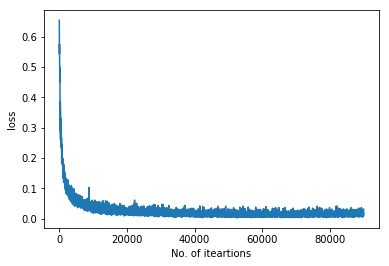

In [13]:
ax = sns.lineplot(batch_ids, losses)
ax.set(xlabel='No. of iteartions', ylabel='loss')
plt.show()